In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('data/data.csv', parse_dates=['Date'])

# Sort by date to ensure chronological order
df = df.sort_values('Date').reset_index(drop=True)

# Ensure 'Up Trend' and 'Down Trend' columns are strings
df['UpTrend'] = df['UpTrend'].astype(str)
df['DownTrend'] = df['DownTrend'].astype(str)

window_size = 15
windows = []
labels = []

for i in range(len(df) - window_size + 1):
    window = df.iloc[i:i + window_size]
    windows.append(window[['Close']].values)
    
    up_count = (window['UpTrend'] == 'UP').sum()
    down_count = (window['DownTrend'] == 'DOWN').sum()
    if up_count > 7:
        labels.append('UP')
    elif down_count > 7:
        labels.append('DOWN')
    else:
        labels.append('MIXED')
    
windows

[array([[139.5],
        [138. ],
        [135.5],
        [133. ],
        [134. ],
        [133. ],
        [133. ],
        [133.5],
        [131.5],
        [137. ],
        [137. ],
        [138. ],
        [134.5],
        [135. ],
        [138.5]]),
 array([[138. ],
        [135.5],
        [133. ],
        [134. ],
        [133. ],
        [133. ],
        [133.5],
        [131.5],
        [137. ],
        [137. ],
        [138. ],
        [134.5],
        [135. ],
        [138.5],
        [139.5]]),
 array([[135.5],
        [133. ],
        [134. ],
        [133. ],
        [133. ],
        [133.5],
        [131.5],
        [137. ],
        [137. ],
        [138. ],
        [134.5],
        [135. ],
        [138.5],
        [139.5],
        [137.5]]),
 array([[133. ],
        [134. ],
        [133. ],
        [133. ],
        [133.5],
        [131.5],
        [137. ],
        [137. ],
        [138. ],
        [134.5],
        [135. ],
        [138.5],
        [139.5],
        

In [3]:
import numpy as np

augmented_windows = []
augmented_labels = []

for i in range(len(windows)):
    original_window = windows[i]
    label = labels[i]
    
    # Flip prices vertically (around a baseline)
    flipped_window = original_window.copy()
    # Flip OHLC values: we reverse price movement
    # Mirror around the first close price (or another reference)
    base_price = original_window[0][-1]  # first close
    flipped_window = base_price - (original_window - base_price)

    # Reverse the label
    if label == 'UP':
        new_label = 'DOWN'
    elif label == 'DOWN':
        new_label = 'UP'
    else:
        new_label = 'MIXED'

    # Save augmented data
    augmented_windows.append(flipped_window)
    augmented_labels.append(new_label)

windows += augmented_windows
labels += augmented_labels

# Augmentation loop (new)
augmented_windows = []
augmented_labels = []

for window, label in zip(windows, labels):
    reversed_window = window[::-1]  # reverse time order
    
    if label == 'UP':
        flipped_label = 'DOWN'
    elif label == 'DOWN':
        flipped_label = 'UP'
    else:
        flipped_label = 'MIXED'
    
    augmented_windows.append(reversed_window)
    augmented_labels.append(flipped_label)

# Combine both
windows = windows + augmented_windows
labels = labels + augmented_labels

In [4]:
from collections import Counter

Counter(labels)

Counter({'UP': 3362, 'DOWN': 3362, 'MIXED': 2000})

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X = np.array(windows)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
y = to_categorical(y, num_classes=3)

X.shape, y.shape

((8724, 15, 1), (8724, 3))

In [6]:
def normalize_windows(X):
    # Normalize per sample
    X_min = X.min(axis=(1, 2), keepdims=True)
    X_max = X.max(axis=(1, 2), keepdims=True)
    X = (X - X_min) / (X_max - X_min + 1e-8)

    # If needed, reshape to (num_samples, 15, 1, 1) for Conv2D
    X = X[..., np.newaxis]  # shape: (num_samples, 15, 1, 1)
    X = X.squeeze(-1)  # shape (num_samples, 15, 1)

    return X

X = normalize_windows(X)
X

array([[[1.        ],
        [0.8125    ],
        [0.5       ],
        ...,
        [0.375     ],
        [0.4375    ],
        [0.875     ]],

       [[0.8125    ],
        [0.5       ],
        [0.1875    ],
        ...,
        [0.4375    ],
        [0.875     ],
        [1.        ]],

       [[0.5       ],
        [0.1875    ],
        [0.3125    ],
        ...,
        [0.875     ],
        [1.        ],
        [0.75      ]],

       ...,

       [[0.        ],
        [0.09090909],
        [0.09090909],
        ...,
        [0.81818182],
        [0.45454545],
        [0.27272727]],

       [[0.        ],
        [0.        ],
        [0.09090909],
        ...,
        [0.54545455],
        [0.81818182],
        [0.45454545]],

       [[0.27272727],
        [0.        ],
        [0.        ],
        ...,
        [0.45454545],
        [0.54545455],
        [0.81818182]]])

In [8]:
X.shape

(8724, 15, 1)

In [10]:
import numpy as np
from pyts.image import GramianAngularField

# Suppose windows is your list of price arrays: shape (n_samples, 15, 1)
X_raw = X.squeeze()  # shape: (n_samples, 15)

# Normalize each window to [-1, 1]
gaf = GramianAngularField(method='summation')

# Transform
X_gaf = gaf.fit_transform(X_raw)  # shape: (n_samples, 15, 15)

# Optional: expand channel dimension for CNN input
X_gaf = X_gaf[..., np.newaxis]  # shape: (n_samples, 15, 15, 1)

X_gaf.shape

(8724, 15, 15, 1)

In [17]:
from sklearn.model_selection import train_test_split

# X: your input data, shape (num_samples, 15, 1) or (num_samples, 15, 1, 1)
# y: your labels, either one-hot or integer-encoded

X_train, X_test, y_train, y_test = train_test_split(
    X_gaf, y, test_size=0.2, random_state=42, stratify=y  # stratify keeps class balance
)

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential


model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(15, 15, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (2, 2), activation='relu'),
    
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')  # for 3 classes: UP, DOWN, MIXED
])


model.compile(optimizer=Adam(learning_rate=0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\nick\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 13, 13, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 6, 6, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,363 (653.76 KB)

 Trainable params: 167,171 (653.01 KB)

 Non-trainable params: 192 (768.00 B)

In [53]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
# class_weights_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256,
        #   class_weight=class_weights_dict
          )


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3444 - loss: 1.4947 - val_accuracy: 0.3862 - val_loss: 1.1883
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3553 - loss: 1.2841 - val_accuracy: 0.3851 - val_loss: 1.0809
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3638 - loss: 1.2156 - val_accuracy: 0.3799 - val_loss: 1.0736
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3760 - loss: 1.1530 - val_accuracy: 0.3885 - val_loss: 1.0725
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3719 - loss: 1.1176 - val_accuracy: 0.3891 - val_loss: 1.0712
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3719 - loss: 1.1052 - val_accuracy: 0.3851 - val_loss: 1.0761
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3783 - loss: 1.1074 - val_accuracy: 0.3891 - val_loss: 1.0727
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3872 - loss: 1.0899 - val_accuracy: 0.

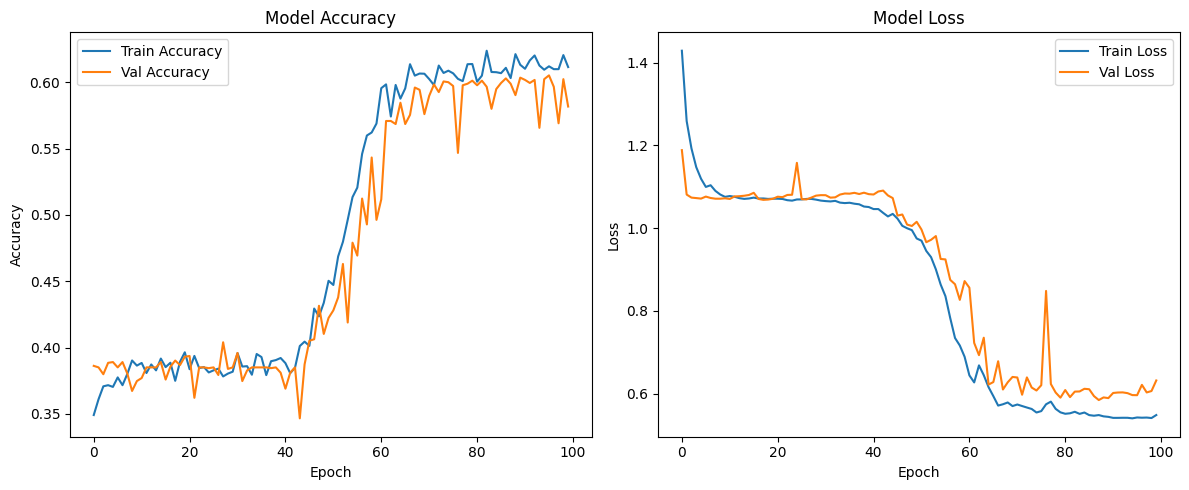

In [54]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [55]:
from sklearn.metrics import classification_report
import numpy as np

# Assume you have:
# X_test: shape (num_samples, 15, 1) or (num_samples, 15, 1, 1)
# y_test: true labels, one-hot encoded (shape: [num_samples, num_classes])

# Step 1: Predict class probabilities
y_pred_probs = model.predict(X_test)

# Step 2: Convert predictions and true labels to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Step 3: Generate the report
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

     Class 0       0.45      0.20      0.28       672
     Class 1       0.93      0.97      0.95       400
     Class 2       0.48      0.73      0.58       673

    accuracy                           0.58      1745
   macro avg       0.62      0.63      0.60      1745
weighted avg       0.57      0.58      0.55      1745

